# Example used in the launch video

In [1]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

In [2]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
TransmonPocket.get_template_options(design)

{'pos_x': '0um',
 'pos_y': '0um',
 'connection_pads': {},
 '_default_connection_pads': {'pad_gap': '15um',
  'pad_width': '125um',
  'pad_height': '30um',
  'pad_cpw_shift': '5um',
  'pad_cpw_extent': '25um',
  'cpw_width': 'cpw_width',
  'cpw_gap': 'cpw_gap',
  'cpw_extend': '100um',
  'pocket_extent': '5um',
  'pocket_rise': '65um',
  'loc_W': '+1',
  'loc_H': '+1'},
 'chip': 'main',
 'pad_gap': '30um',
 'inductor_width': '20um',
 'pad_width': '455um',
 'pad_height': '90um',
 'pocket_width': '650um',
 'pocket_height': '650um',
 'orientation': '0',
 'hfss_wire_bonds': False,
 'q3d_wire_bonds': False,
 'hfss_inductance': '10nH',
 'hfss_capacitance': 0,
 'hfss_resistance': 0,
 'hfss_mesh_kw_jj': 7e-06,
 'q3d_inductance': '10nH',
 'q3d_capacitance': 0,
 'q3d_resistance': 0,
 'q3d_mesh_kw_jj': 7e-06,
 'gds_cell_name': 'my_other_junction'}

### Default settings for trace width and trace gap

In [3]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

### 4 transmons (3 pins each) + 4 CPWs

In [4]:
# Allow running the same cell here multiple times to overwrite changes
design.overwrite_enabled = True

## Custom options for all the transmons
options = dict(
    # Some options we want to modify from the defaults
    # (see below for defaults)
    pad_width = '425 um', 
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(
        a = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

## Create 4 transmons

q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.42251mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.95mm', orientation = '270', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.42251mm', pos_y='+0.0mm', orientation = '180', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.95mm', orientation = '90', **options))

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
RouteMeander.get_template_options(design)

options = Dict(
        lead=Dict(
            start_straight='0.2mm',
            end_straight='0.2mm'),
        trace_gap='9um',
        trace_width='15um')

def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='90um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)

asym = 140
cpw1 = connect('cpw1', 'Q1', 'c', 'Q2', 'b', '5.6 mm', f'+{asym}um')
cpw2 = connect('cpw2', 'Q3', 'b', 'Q2', 'c', '5.7 mm', f'-{asym}um', flip=True)
cpw3 = connect('cpw3', 'Q3', 'c', 'Q4', 'b', '5.6 mm', f'+{asym}um')
cpw4 = connect('cpw4', 'Q1', 'b', 'Q4', 'c', '5.7 mm', f'-{asym}um', flip=True)

gui.rebuild()
gui.autoscale()

### 4 Open to Ground Pins

In [5]:
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround

otg1 = OpenToGround(design, 'OTG1', options = dict(pos_x='2771um', pos_y='0', orientation='180', gap='9um', width='15um'))
otg2 = OpenToGround(design, 'OTG2', options = dict(pos_x='0um', pos_y='-1301um', orientation='90', gap='9um', width='15um'))
otg3 = OpenToGround(design, 'OTG3', options = dict(pos_x='-2771um', pos_y='0', orientation='0', gap='9um', width='15um'))
otg4 = OpenToGround(design, 'OTG4', options = dict(pos_x='0um', pos_y='1301um', orientation='270', gap='9um', width='15um'))

### V1 Launchers

In [6]:
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

p1_c = LaunchpadWirebond(design, 'P1_C', options = dict(pos_x='4000um', pos_y='2812um', orientation='270', lead_length='0um', cpw_gap='9um', cpw_width='15um'))
p2_c = LaunchpadWirebond(design, 'P2_C', options = dict(pos_x='4000um', pos_y='-2812um', orientation='90', lead_length='0um', cpw_gap='9um', cpw_width='15um'))
p3_c = LaunchpadWirebond(design, 'P3_C', options = dict(pos_x='-4000um', pos_y='-2812um', orientation='90', lead_length='0um', cpw_gap='9um', cpw_width='15um'))
p4_c = LaunchpadWirebond(design, 'P4_C', options = dict(pos_x='-4000um', pos_y='2812um', orientation='270', lead_length='0um', cpw_gap='9um', cpw_width='15um'))


### V2 Launchers

In [7]:
from qiskit_metal.qlibrary.terminations.launchpad_wb_coupled import LaunchpadWirebondCoupled

p1_q = LaunchpadWirebondCoupled(design, 'P1_Q', options = dict(pos_x='4020um', pos_y='0', orientation='180', lead_length='0um', cpw_gap='9um', cpw_width='15um'))
p2_q = LaunchpadWirebondCoupled(design, 'P2_Q', options = dict(pos_x='-990um', pos_y='-2812um', orientation='90', lead_length='0um', cpw_gap='9um', cpw_width='15um'))
p3_q = LaunchpadWirebondCoupled(design, 'P3_Q', options = dict(pos_x='-4020um', pos_y='0', orientation='0', lead_length='0um', cpw_gap='9um', cpw_width='15um'))
p4_q = LaunchpadWirebondCoupled(design, 'P4_Q', options = dict(pos_x='990um', pos_y='2812um', orientation='270', lead_length='0um', cpw_gap='9um', cpw_width='15um'))

gui.rebuild()
gui.autoscale()

### Charge Lines to Corners

In [8]:
import numpy as np
from collections import OrderedDict

from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors

anchors1c = OrderedDict()
anchors1c[0] = np.array([3, 0])
anchors1c[1] = np.array([3, 2.5]) 
anchors1c[2] = np.array([4, 2.5])

options_line_cl1 = {'pin_inputs': 
            {'start_pin': {'component': 'OTG1', 'pin': 'open'}, 
             'end_pin': {'component': 'P1_C', 'pin': 'tie'}},
            'leadin': {'start': '0um', 'end': '0um'},
            'anchors': anchors1c,
            'trace_gap': '9um',
            'trace_width': '15um',
            'fillet': '90um'        
            }

cl1 = RouteAnchors(design, 'line_cl1', options_line_cl1)

anchors2c = OrderedDict()
anchors2c[0] = np.array([0, -1.5])
anchors2c[1] = np.array([2, -1.5]) 
anchors2c[2] = np.array([2, -2.5])
anchors2c[3] = np.array([4, -2.5])

options_line_cl2 = {'pin_inputs': 
            {'start_pin': {'component': 'OTG2', 'pin': 'open'}, 
             'end_pin': {'component': 'P2_C', 'pin': 'tie'}},
            'leadin': {'start': '0um', 'end': '0um'},
            'anchors': anchors2c,
            'fillet': '90um',
            'trace_gap': '9um',
            'trace_width': '15um'
            }

cl2 = RouteAnchors(design, 'line_cl2', options_line_cl2)

anchors3c = OrderedDict()
anchors3c[0] = np.array([-3, 0])
anchors3c[1] = np.array([-3, -2.5]) 
anchors3c[2] = np.array([-4, -2.5])

options_line_cl3 = {'pin_inputs': 
            {'start_pin': {'component': 'OTG3', 'pin': 'open'}, 
             'end_pin': {'component': 'P3_C', 'pin': 'tie'}},
            'leadin': {'start': '0um', 'end': '0um'},
            'anchors': anchors3c,
            'fillet': '90um',
            'trace_gap': '9um',
            'trace_width': '15um'
            }

cl3 = RouteAnchors(design, 'line_cl3', options_line_cl3)

anchors4c = OrderedDict()
anchors4c[0] = np.array([0, 1.5])
anchors4c[1] = np.array([-2, 1.5]) 
anchors4c[2] = np.array([-2, 2.5])
anchors4c[3] = np.array([-4, 2.5])

options_line_cl4 = {'pin_inputs': 
            {'start_pin': {'component': 'OTG4', 'pin': 'open'}, 
             'end_pin': {'component': 'P4_C', 'pin': 'tie'}},
            'leadin': {'start': '0um', 'end': '0um'},
            'anchors': anchors4c,
            'fillet': '90um',
            'trace_gap': '9um',
            'trace_width': '15um'
            }

cl4 = RouteAnchors(design, 'line_cl4', options_line_cl4)

gui.rebuild()
gui.autoscale()

### Exchange Coupler Lines

In [9]:
options = Dict(
        lead=Dict(
            start_straight='0.35mm',
            end_straight='0.15mm'),
        trace_gap='9um',
        trace_width='15um')

ol1 = connect('ol1', 'Q1', 'a', 'P1_Q', 'tie', '5.5 mm', f'+{asym}um', flip=True)
ol2 = connect('ol2', 'Q2', 'a', 'P2_Q', 'tie', '13.0 mm', f'+{asym}um', flip=True)
ol3 = connect('ol3', 'Q3', 'a', 'P3_Q', 'tie', '5.5 mm', f'+{asym}um', flip=True)
ol4 = connect('ol4', 'Q4', 'a', 'P4_Q', 'tie', '13.0 mm', f'+{asym}um', flip=True)

gui.rebuild()
gui.autoscale()

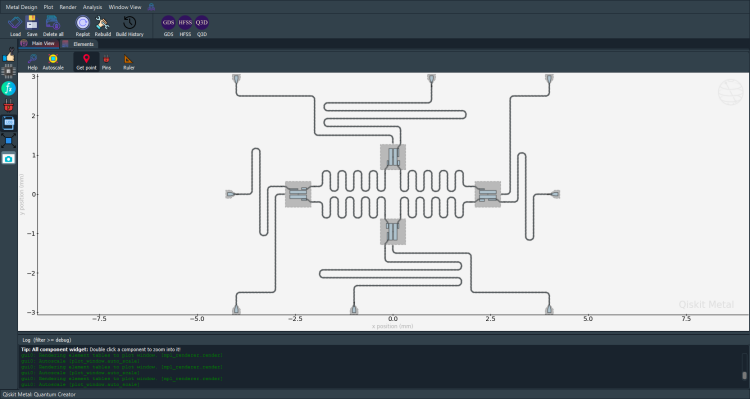

In [10]:
gui.screenshot()

### Export to GDS

In [11]:
#QDesign enables GDS renderer during init.
a_gds = design.renderers.gds

a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [12]:
#If you have a fillet_value and there are LineSegments that are shorter than 2*fillet_value, 
#When true, the short segments will not be fillet'd. 
a_gds.options['short_segments_to_not_fillet'] = 'True'
SCALE_FILLET = 2.0
a_gds.options['check_short_segments_by_scaling_fillet'] = SCALE_FILLET
a_gds.options['path_filename'] = '../resources/Fake_Junctions.GDS'

In [13]:
# Export GDS file for all components in design.
# Please change the path where you want to write a GDS file.

#def export_to_gds(self, file_name: str, highlight_qcomponents: list = []) -> int:
a_gds.export_to_gds("Launch_Notebook.gds")

02:37PM 16s WARNING [_cheese_buffer_maker]: The bounding box for no-cheese is outside of chip size.
Bounding box for chip is (-4.5, -3.0, 4.5, 3.0).
Bounding box with no_cheese buffer is (-4.295000000000001, -3.087, 4.295000000000001, 3.087).


1

In [ ]:
gui.main_window.close()

KeyboardInterrupt: 

# END of first video.

# Below, other launch video. requires Ansys previous setup

In [ ]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

In [ ]:
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer

QAnsysRenderer.default_options

In [ ]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket

In [ ]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

In [ ]:
# Allow running the same cell here multiple times to overwrite changes
design.overwrite_enabled = True

## Custom options for all the transmons
options = dict(
    # Some options we want to modify from the defaults
    # (see below for defaults)
    pad_width = '425 um', 
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(
        a = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

## Create 4 transmons

q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.42251mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.95mm', orientation = '270', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.42251mm', pos_y='+0.0mm', orientation = '180', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.95mm', orientation = '90', **options))

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
RouteMeander.get_template_options(design)

options = Dict(
        lead=Dict(
            start_straight='0.2mm',
            end_straight='0.2mm'),
        trace_gap='9um',
        trace_width='15um')

def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='90um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)

asym = 140
cpw1 = connect('cpw1', 'Q1', 'c', 'Q2', 'b', '5.6 mm', f'+{asym}um')
cpw2 = connect('cpw2', 'Q3', 'b', 'Q2', 'c', '5.7 mm', f'-{asym}um', flip=True)
cpw3 = connect('cpw3', 'Q3', 'c', 'Q4', 'b', '5.6 mm', f'+{asym}um')
cpw4 = connect('cpw4', 'Q1', 'b', 'Q4', 'c', '5.7 mm', f'-{asym}um', flip=True)

gui.rebuild()
gui.autoscale()

In [ ]:
fourq = design.renderers.hfss

In [ ]:
# this will error out if Ansys is not configured correctly. Also you will need to open Ansys before connecting.
fourq.connect_ansys()

In [ ]:
fourq.add_eigenmode_design("FourQ")

In [ ]:
fourq.render_design([], [])

In [ ]:
fourq.disconnect_ansys()